<font color="#04B404"><h1 align="center">ML</h1></font>
<font color="#6E6E6E"><h2 align="center">Diamonds dataset</h2></font>
<br>
<span>In this notebook we analyse a well-known dataset in ml: diamonds price's dataset (https://www.kaggle.com/shivam2503/diamonds?select=diamonds.csv). For that we use basic ml python tools such as pandas, numpy and sklearn.</span>

In [60]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [61]:
# Importing data
data = pd.read_csv('./data/diamonds.csv')

In [62]:
# Sneak peek to data
display(data.head(5))
print(data.shape)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


(53940, 11)


### <font color="#CA3532">Data audit & preprocessing</font>

In [63]:
data = data.drop(['Unnamed: 0'], axis = 1)
data.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [64]:
# Numeric features
data.describe(include = 'object')

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


In [65]:
# Categoric features
data.describe(include = 'number')

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


We observe that we have 3 categorical features and 7 numerical ones. Price feature is target.
Features x, y and z have min values of 0.0, which can't be possible. Let's see if there are many patterns with that value:

In [66]:
len(data[(data['x']==0) | (data['y']==0) | (data['z']==0)])

20

Which are very few data: we drop those patterns:

In [73]:
for var in ['x', 'y', 'z']:
    data.drop(data[data[var] == 0].index, axis=0, inplace=True)

In [56]:
# Missing values
for feature in data.columns:
    if data[feature].isnull().any():
        print('{0} has {1} null values.'.format(feature, data[feature].isnull().sum()))

So we have no missing values.

Visualizing data:

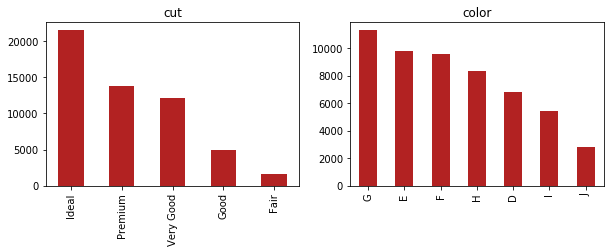

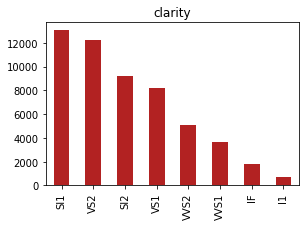

In [16]:
# Histograms for categorical data:
categorical_data = data.loc[:, data.dtypes == object]

for index, var in enumerate(categorical_data.columns):
    if index%2 == 0:
        plt.figure(figsize=(10,3))
    plt.subplot(1,2,index%2+1)
    p = categorical_data[var].value_counts().plot(kind = 'bar', color='firebrick', title = var)
    if index%2 == 1:
        plt.show() 

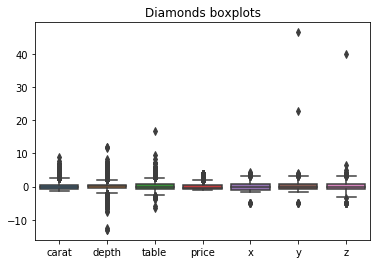

In [18]:
# Boxplots and histograms/scatterplots for numeric data
# Normalizing numerical data over z-scoring
numerical_data = data.loc[:, data.dtypes != object]
data_norm = (numerical_data - numerical_data.mean())/numerical_data.std()

bx_plot = sns.boxplot(data=data_norm)
plt.title('Diamonds boxplots')
plt.show()